In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
!pip install torchmetrics

In [ ]:
!pip install pytorch_lightning

In [ ]:
!pip install torchxlstm

In [ ]:
#DATA_PATH_CLEAN = '/content/drive/MyDrive/Nhóm 6 - DS317.P11/ĐỒ ÁN MÔN HỌC/3.data_processing/data-final/tabular_lstm/tabular_lstm_clean.csv'
#DATA_PATH_RAW = '/content/drive/MyDrive/Nhóm 6 - DS317.P11/ĐỒ ÁN MÔN HỌC/3.data_processing/data-final/tabular_lstm/tabular_lstm_raw.csv'
df = pd.read_csv
features = df.iloc[:, :-1]  # All rows, all columns except the last
labels = df.iloc[:, -1]     # All rows, only the last column
from sklearn.model_selection import train_test_split

# Assuming `X` is your dataset features and `y` is your labels
# Replace `X` and `y` with your actual data

# Step 1: Split into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)
#
# Step 2: Split temp into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Final ratio: 80% train, 10% validation, 10% test
#ĐƯỜNG DẪN ĐẾN FOLDER
VAL_TEST_TRAIN_FOLDER_PATH = '/content/drive/MyDrive/Nhóm 6 - DS317.P11/ĐỒ ÁN MÔN HỌC/3.data_processing/data-final/tabular_lstm/train-val-test-raw4label'
# Step 1: Concatenate features and labels for each dataset
train_data = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train, columns=["label"])], axis=1)
val_data = pd.concat([pd.DataFrame(X_val), pd.DataFrame(y_val, columns=["label"])], axis=1)
test_data = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test, columns=["label"])], axis=1)
# Step 2: Export to CSV files
train_data.to_csv(f"{VAL_TEST_TRAIN_FOLDER_PATH}/train_data.csv", index=False)
val_data.to_csv(f"{VAL_TEST_TRAIN_FOLDER_PATH}/val_data.csv", index=False)
test_data.to_csv(f"{VAL_TEST_TRAIN_FOLDER_PATH}/test_data.csv", index=False)

print("Data exported to CSV successfully!")

Data exported to CSV successfully!


In [ ]:
# "khoa_CNPM", "khoa_HTTT", "khoa_KHMT", "khoa_KTMT",
#     "khoa_KTTT", "khoa_MMT&TT"
#"noisinh_0", "noisinh_1", "noisinh_2", "noisinh_3", "noisinh_4", "noisinh_5", "noisinh_6"

In [ ]:
base_columns = [
    "mssv", "diem_tt", "OTHER", "THPT", "ĐGNL", "hedt_CLC", "hedt_CNTN", "hedt_CQUI",
    "hedt_CTTT", "hedt_KSTN", "chuyennganh2_7340122_CLC", "chuyennganh2_7340122_CQ",
    "chuyennganh2_7480101_CLC", "chuyennganh2_7480101_CQ", "chuyennganh2_7480101_CTTN",
    "chuyennganh2_7480102_CLC", "chuyennganh2_7480102_CQ", "chuyennganh2_7480103_CLC",
    "chuyennganh2_7480103_CQ", "chuyennganh2_7480104_CLC", "chuyennganh2_7480104_CQ",
    "chuyennganh2_7480104_CTTT", "chuyennganh2_7480106_CLC", "chuyennganh2_7480106_CQ",
    "chuyennganh2_7480109_CQ", "chuyennganh2_7480201_CLC", "chuyennganh2_7480201_CQ",
    "chuyennganh2_7480202_CLC", "chuyennganh2_7480202_CQ", "chuyennganh2_7480202_CTTN",
]

In [ ]:
selected_cols_1_years = ['sem1','sem2','sem3','term 1','term 2','label']#6
selected_cols_2_years = ['sem1','sem2','sem3','sem4','sem5','sem6','term 1','term 2','term 3','term 4','label']#11
selected_cols_3_years = ['sem1','sem2','sem3','sem4','sem5','sem6','sem7','sem8','sem9','term 1','term 2','term 3','term 4','term 5','term 6','label']#16
selected_cols_3_5_years = ['sem1','sem2','sem3','sem4','sem5','sem6','sem7','sem8','sem9','sem10','term 1','term 2','term 3','term 4','term 5','term 6','term 7','label']#18

In [ ]:
oneyear =base_columns+selected_cols_1_years
twoyears = base_columns+selected_cols_2_years
threeyears =base_columns+selected_cols_3_years
three5years = base_columns+selected_cols_3_5_years

In [ ]:
df_train = pd.read_csv(f"{VAL_TEST_TRAIN_FOLDER_PATH}/train_data.csv")

In [ ]:
print(len(base_columns))

30


In [ ]:
print(len(selected_cols_1_years))

6


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassF1Score, MulticlassPrecision, MulticlassRecall, MulticlassAccuracy
import pytorch_lightning as pl
import matplotlib.pyplot as plt
#from torchxlstm import sLSTM, mLSTM, xLSTM
TABULAR_SIZE = 29
TABULAR_LSTM_SIZE = 39 #2nam cho 3 hoc ki
#nam 1: 27
#nam 2: 32
#nam 3: 37
#3.5: 39
LSTM_SIZE = TABULAR_LSTM_SIZE - TABULAR_SIZE
MODEL_TYPE = 'lstm'
#mlp, mlp_lstm, mlp_bilstm,lstm, bilstm
EPOCHS = 20
empty_results_df = pd.DataFrame(columns=["Model","Accuracy", "F1", "Precision", "Recall"])
empty_results_df_v2 = pd.DataFrame(columns=["Model","Accuracy", "F1", "Precision", "Recall"])
class TabularTimeSeriesModel(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, output_size, lr=0.001, model_type='mlp',file_name = "default"):
        super(TabularTimeSeriesModel, self).__init__()
        self.save_hyperparameters()
        if model_type == 'lstm':
            print("lstm")
            self.model = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)
        elif model_type == 'bilstm':
            print("bilstm")
            self.model = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
            self.fc = nn.Linear(hidden_size * 2, output_size)
        elif model_type == 'mlp_lstm':  # MLP-LSTM directly embedded here
            print("mlp_lstm")
            self.fc1 = nn.Linear(TABULAR_SIZE, 32)
            self.fc2 = nn.Linear(32, 64)
            self.fc3 = nn.Linear(64, 32)
            self.fc5 = nn.Linear(32, output_size)
            self.norm1 = nn.LayerNorm(32)
            self.norm2 = nn.LayerNorm(64)
            self.norm3 = nn.LayerNorm(32)

            self.lstm1 = nn.LSTM(input_size, 32, batch_first=True)
            self.lstm2 = nn.LSTM(32, 64, batch_first=True)
            self.lstm3 = nn.LSTM(64, 32, batch_first=True)
        elif model_type == 'mlp':
            print("mlp")
            self.fc1 = nn.Linear(TABULAR_SIZE, hidden_size)
            self.hidden_layers = nn.ModuleList(
                [nn.Linear(hidden_size, hidden_size) for _ in range(8)]  # 3 hidden layers
            )
            self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hidden_size) for _ in range(3)])
            self.dropout = nn.Dropout(p=0.5)
            self.fc2 = nn.Linear(hidden_size, output_size)
        elif model_type == 'mlp_bilstm':
            print("mlp_bilstm")
            # MLP + BiLSTM model definition
            self.fc1 = nn.Linear(TABULAR_SIZE, 32)
            self.fc2 = nn.Linear(32, 64)
            self.fc3 = nn.Linear(64, 32)
            self.fc5 = nn.Linear(32, output_size)
            self.norm1 = nn.LayerNorm(32)
            self.norm2 = nn.LayerNorm(64)
            self.norm3 = nn.LayerNorm(32)

            # BiLSTM layers
            self.lstm1 = nn.LSTM(input_size, 16, batch_first=True, bidirectional=True)
            self.lstm2 = nn.LSTM(32, 32, batch_first=True, bidirectional=True)
            self.lstm3 = nn.LSTM(64, 16, batch_first=True, bidirectional=True)
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        # Loss function
        self.loss_fn = nn.CrossEntropyLoss()

        # Metrics
        self.train_acc = MulticlassAccuracy(num_classes=output_size,average='macro')
        self.val_f1 = MulticlassF1Score(num_classes=output_size,average='macro')
        self.val_precision = MulticlassPrecision(num_classes=output_size,average='macro')
        self.val_recall = MulticlassRecall(num_classes=output_size,average='macro')
        self.test_acc = MulticlassAccuracy(num_classes=output_size,average='macro')
        self.test_f1 = MulticlassF1Score(num_classes=output_size,average='macro')
        self.test_precision = MulticlassPrecision(num_classes=output_size,average='macro')
        self.test_recall = MulticlassRecall(num_classes=output_size,average='macro')

        # Metrics
        self.test_acc_v2 = MulticlassAccuracy(num_classes=output_size,average='micro')
        self.test_f1_v2 = MulticlassF1Score(num_classes=output_size,average='weighted')
        self.test_precision_v2 = MulticlassPrecision(num_classes=output_size,average='weighted')
        self.test_recall_v2 = MulticlassRecall(num_classes=output_size,average='weighted')

        # Loss tracking for visualization
        self.training_losses = []
        self.validation_losses = []
        self.training_losses_avg = []
        self.validation_losses_avg = []

    def forward(self, x):
        if self.hparams.model_type in ['lstm', 'bilstm']:
            if x.ndim == 2:
                x_LSTM = x[:, TABULAR_SIZE:].unsqueeze(1)  # Add sequence dimension for LSTM/BiLSTM
            else:
                x_LSTM = x[:, TABULAR_SIZE:]  # If x is already 3D, just extract the relevant part

            out, _ = self.model(x_LSTM)  # Process with LSTM/BiLSTM
            out = self.fc(out[:, -1, :])  # Use the last hidden state for classification
            out = F.log_softmax(out, dim=1)  # Multi-class classification
        elif self.hparams.model_type == 'mlp':
            x_mlp = x[:, :TABULAR_SIZE]  # First part for MLP
            x = torch.relu(self.fc1(x_mlp))
            for hidden_layer, batch_norm in zip(self.hidden_layers, self.batch_norms):
                x = hidden_layer(x)
                x = batch_norm(x)
                x = torch.relu(x)
                x = self.dropout(x)
            out = self.fc2(x)
            out = F.log_softmax(out, dim=1)  # Multi-class classification
            return out
        elif self.hparams.model_type == 'mlp_lstm':
            # # Split the input for MLP and LSTM components
            x_MLP = x[:, :TABULAR_SIZE]  # First 15 columns for MLP
            x_LSTM = x[:, TABULAR_SIZE:].unsqueeze(1)  # Columns 16 to 33 for LSTM with sequence dim
            #print(x_LSTM.size())
            # LSTM layers
            x_LSTM1, _ = self.lstm1(x_LSTM)
            x_LSTM2, _ = self.lstm2(x_LSTM1)
            x_LSTM3, _ = self.lstm3(x_LSTM2)

            # MLP layers
            x_MLP = F.relu(self.norm1(self.fc1(x_MLP)))
            x_MLP = x_MLP + x_LSTM1.squeeze(1)  # Align dimensions after LSTM
            x_MLP = F.relu(self.norm2(self.fc2(x_MLP)))
            x_MLP = x_MLP + x_LSTM2.squeeze(1)  # Align dimensions after LSTM
            x_MLP = F.relu(self.norm3(self.fc3(x_MLP)))
            x_MLP = x_MLP + x_LSTM3.squeeze(1)  # Align dimensions after LSTM
            out = self.fc5(x_MLP)
            out = F.log_softmax(out, dim=1)  # Multi-class classification
            return out
        elif self.hparams.model_type == 'mlp_bilstm':
            # Split the input for MLP and BiLSTM components
            x_MLP = x[:, :TABULAR_SIZE]  # First 15 columns for MLP
            x_LSTM = x[:, TABULAR_SIZE:].unsqueeze(1)  # Columns 16 to 33 for BiLSTM (ensure sequence dimension)

            # BiLSTM layers
            x_LSTM1, _ = self.lstm1(x_LSTM)
            x_LSTM2, _ = self.lstm2(x_LSTM1)
            x_LSTM3, _ = self.lstm3(x_LSTM2)

            # MLP layers (feature extraction)
            x_MLP = F.relu(self.norm1(self.fc1(x_MLP)))
            x_MLP = x_MLP + x_LSTM1.squeeze(1)  # Combine MLP and BiLSTM output
            x_MLP = F.relu(self.norm2(self.fc2(x_MLP)))
            x_MLP = x_MLP + x_LSTM2.squeeze(1)  # Combine MLP and BiLSTM output
            x_MLP = F.relu(self.norm3(self.fc3(x_MLP)))
            x_MLP = x_MLP + x_LSTM3.squeeze(1)  # Combine MLP and BiLSTM output

            # Final output layer
            out = self.fc5(x_MLP)
            out = F.log_softmax(out, dim=1)  # Multi-class classification
            return out
        else:
            raise ValueError(f"Unsupported model type: {self.hparams.model_type}")
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        predicted_classes = y_hat.argmax(dim=1)
        loss = self.loss_fn(y_hat, y)
        acc = self.train_acc(y_hat, y)
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        self.training_losses.append(loss.item())
        return loss
    def on_train_epoch_end(self):
        print("trainning end")
        # Calculate the average training loss for the epoch
        avg_train_loss = sum(self.training_losses) / len(self.training_losses)
        self.log("avg_train_loss", avg_train_loss, prog_bar=True)
        self.training_losses_avg.append(avg_train_loss)
        # Clear the training_losses for the next epoch
        self.training_losses = []

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        predicted_classes = y_hat.argmax(dim=1)
        loss = self.loss_fn(y_hat, y)

        # Calculate metrics
        f1 = self.val_f1(y_hat, y)
        precision = self.val_precision(y_hat, y)
        recall = self.val_recall(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()

        # Log metrics
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)
        self.log("val_precision", precision, prog_bar=True)
        self.log("val_recall", recall, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.validation_losses.append(loss.item())
        return {"val_loss": loss, "val_f1": f1, "val_precision": precision, "val_recall": recall, "val_acc": acc}
    def on_validation_epoch_end(self):
        print("validation end")
        # Calculate the average validation loss for the epoch
        avg_val_loss = sum(self.validation_losses) / len(self.validation_losses)
        self.log("avg_val_loss", avg_val_loss, prog_bar=True)
        self.validation_losses_avg.append(avg_val_loss)
        # Clear the validation_losses for the next epoch
        self.validation_losses = []

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)  # Get model predictions
        loss = self.loss_fn(y_hat, y)  # Compute loss

        # Store predictions and ground truth labels for later aggregation
        self.preds = self.preds if hasattr(self, 'preds') else []
        self.targets = self.targets if hasattr(self, 'targets') else []
        self.preds.append(y_hat)
        self.targets.append(y)

        # Return loss, which will be aggregated later
        return {"test_loss": loss}

    def on_test_epoch_end(self):
        print("test end")
        # Concatenate all the predictions and targets from test_step
        all_preds = torch.cat(self.preds, dim=0)
        predicted_classes = all_preds.argmax(dim=1)
        print(f'\npredicted class raw {all_preds}\n')
        print(f'\npredicted class {predicted_classes}\n')
        print(f'\ntarget class {self.targets}\n')
        all_targets = torch.cat(self.targets, dim=0).view(-1)
        print(f"Shape of predictions: {all_preds.shape}")
        print(f"Shape of targets: {all_targets.shape}")
        print(f'\ntarget class {self.targets}\n')
        # Get the length of the concatenated tensors
        num_samples = all_preds.size(0)

        print(f"Number of samples in predictions and targets: {num_samples}")
        # Calculate metrics on the entire dataset
        f1 = self.test_f1(all_preds, all_targets)
        precision = self.test_precision(all_preds, all_targets)
        recall = self.test_recall(all_preds, all_targets)
        acc = self.test_acc(all_preds, all_targets)

        f1_v2 = self.test_f1_v2(all_preds, all_targets)
        precision_v2 = self.test_precision_v2(all_preds, all_targets)
        recall_v2 = self.test_recall_v2(all_preds, all_targets)
        acc_v2 = self.test_acc_v2(all_preds, all_targets)
        # Aggregate loss (calculate the average of all losses)
        #avg_test_loss = torch.tensor([x["test_loss"] for x in self.trainer.test_loop.outputs]).mean().item()

        # Log the aggregated metrics
        #self.log("avg_test_loss", avg_test_loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)
        self.log("test_precision", precision, prog_bar=True)
        self.log("test_recall", recall, prog_bar=True)

        self.log("test_acc_v2", acc_v2, prog_bar=True)
        self.log("test_f1_v2", f1_v2, prog_bar=True)
        self.log("test_precision_v2", precision_v2, prog_bar=True)
        self.log("test_recall_v2", recall_v2, prog_bar=True)
        # Save metrics to a CSV file
        results = {
            "Model": [self.hparams.model_type],
            "Accuracy": acc,
            "F1": f1,
            "Precision": precision,
            "Recall": recall,
        }
        results_v2 = {
            "Model": [self.hparams.model_type],
            "Accuracy": acc_v2,
            "F1": f1_v2,
            "Precision": precision_v2,
            "Recall": recall_v2,
        }
        # Convert results to a DataFrame
        results_df = pd.DataFrame(results)
        results_df_v2 = pd.DataFrame(results_v2)
        # Append results to the global empty results DataFrame
        global empty_results_df
        global empty_results_df_v2
        empty_results_df = pd.concat([empty_results_df, results_df], ignore_index=True)
        empty_results_df_v2 = pd.concat([empty_results_df_v2, results_df_v2], ignore_index=True)

        # Optionally save the DataFrame to a CSV file
        #empty_results_df.to_csv("model_results.csv", index=False)
        # Print the final test metrics
        print(f" Accuracy: {acc}, F1: {f1}, Precision: {precision}, Recall: {recall}")


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

    def visualize_training(self, train_losses, val_losses):
        epochs = range(1, len(train_losses) + 1)  # Create a range for the x-axis
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_losses, label="Average Training Loss")
        plt.plot(epochs, val_losses, label="Average Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss Over Epochs")
        plt.legend()
        plt.grid(True)
        plt.show()


In [ ]:
model = TabularTimeSeriesModel.load_from_checkpoint('/content/lightning_logs/version_2/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 34, model mlp_bilstm.ckpt')
model.freeze()


mlp_bilstm


In [ ]:
model = TabularTimeSeriesModel.load_from_checkpoint('/content/lightning_logs/version_2/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 34, model mlp_bilstm.ckpt')
model.freeze()

dataset_test = pd.read_csv('/content/drive/MyDrive/Nhóm 6 - DS317.P11/ĐỒ ÁN MÔN HỌC/3.data_processing/data-final/tabular_lstm/train-val-test-clean/test_data.csv')
dataset_test = dataset_test[three5years]

#prepare data for testing
x_test = dataset_test.drop(columns=['mssv','label'])
#x_test = dataset_test[oneyear].values
x_test = x_test.iloc[:, :TABULAR_LSTM_SIZE].values  # Select the first 21 columns after dropping
y_test = dataset_test['label'].values

X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(y_test, dtype=torch.long)

mlp_bilstm


In [ ]:
!rm -r lightning_logs

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | fc1               | Linear              | 480    | train
1  | hidden_layers     | ModuleList          | 2.2 K  | train
2  | batch_norms       | ModuleList          | 96     | train
3  | dropout           | Dropout             | 0      | train
4  | fc2               | Linear              | 85     | train
5  | loss_fn           | CrossEntropyLoss    | 0      | train
6  | train_acc         | MulticlassAccuracy  | 0      | train
7  | val_f1            | MulticlassF1Score   | 0      | train
8  | val_precision     | MulticlassPrecision | 0      | train
9  | val_recall        |

mlp
twoyears
mlp


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

validation end


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 56: 'val_loss' reached 1.49115 (best 1.49115), saving model to '/content/lightning_logs/version_0/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 112: 'val_loss' reached 1.35950 (best 1.35950), saving model to '/content/lightning_logs/version_0/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 168: 'val_loss' reached 1.23469 (best 1.23469), saving model to '/content/lightning_logs/version_0/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 224: 'val_loss' reached 1.16751 (best 1.16751), saving model to '/content/lightning_logs/version_0/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 280: 'val_loss' reached 1.09556 (best 1.09556), saving model to '/content/lightning_logs/version_0/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 336: 'val_loss' reached 1.07046 (best 1.07046), saving model to '/content/lightning_logs/version_0/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 392: 'val_loss' reached 1.06590 (best 1.06590), saving model to '/content/lightning_logs/version_0/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 448: 'val_loss' reached 1.05126 (best 1.05126), saving model to '/content/lightning_logs/version_0/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 504: 'val_loss' reached 1.04814 (best 1.04814), saving model to '/content/lightning_logs/version_0/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 560: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 616: 'val_loss' reached 1.04175 (best 1.04175), saving model to '/content/lightning_logs/version_0/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 672: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 728: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 784: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 840: 'val_loss' reached 1.04140 (best 1.04140), saving model to '/content/lightning_logs/version_0/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 896: 'val_loss' reached 1.04029 (best 1.04029), saving model to '/content/lightning_logs/version_0/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 952: 'val_loss' reached 1.03946 (best 1.03946), saving model to '/content/lightning_logs/version_0/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 1008: 'val_loss' reached 1.03921 (best 1.03921), saving model to '/content/lightning_logs/version_0/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 1064: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 1120: 'val_loss' reached 1.03837 (best 1.03837), saving model to '/content/lightning_logs/version_0/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


validation end
trainning end


Testing: |          | 0/? [00:00<?, ?it/s]

test end

predicted class raw tensor([[-1.7786, -0.6090, -1.2702, -5.3408, -6.4005],
        [-1.7786, -0.6090, -1.2702, -5.3407, -6.4005],
        [-1.7787, -0.6092, -1.2699, -5.3384, -6.3921],
        ...,
        [-1.7790, -0.6090, -1.2699, -5.3392, -6.3957],
        [-1.7791, -0.6090, -1.2699, -5.3393, -6.3958],
        [-1.7793, -0.6091, -1.2697, -5.3385, -6.3898]])


predicted class tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.25            │
│        test_acc_v2        │     0.510597288608551     │
│          test_f1          │    0.16900509595870972    │
│        test_f1_v2         │    0.3451741933822632     │
│      test_precision       │    0.12764932215213776    │
│     test_precision_v2     │    0.26070961356163025    │
│        test_recall        │           0.25            │
│      test_recall_v2       │     0.510597288608551     │
└───────────────────────────┴───────────────────────────┘

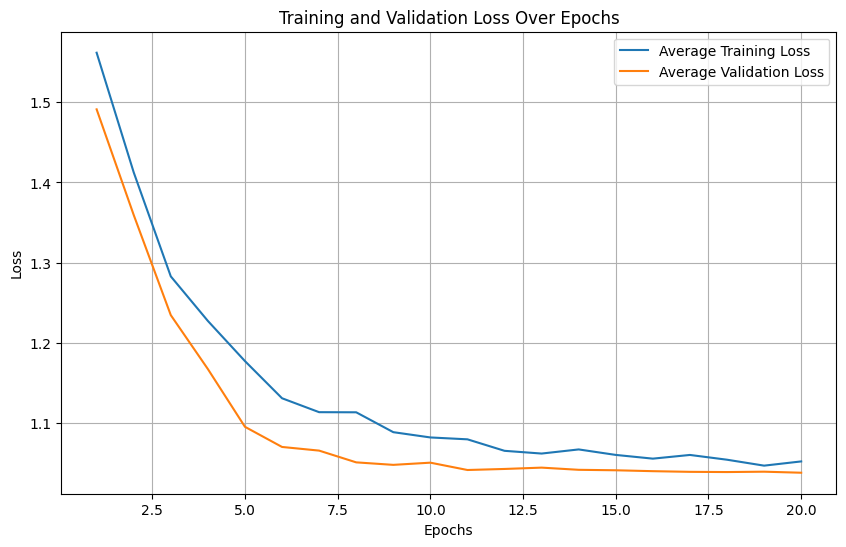

None
mlp_lstm
twoyears
mlp_lstm


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | fc1               | Linear              | 960    | train
1  | fc2               | Linear              | 2.1 K  | train
2  | fc3               | Linear              | 2.1 K  | train
3  | fc5               | Linear              | 165    | train
4  | norm1             | LayerNorm           | 64     | train
5  | norm2             | LayerNorm           | 128    | train
6  | norm3             | LayerNorm           | 64     | train
7  | lstm1             | LSTM                | 5.6 K  | train
8  | lstm2             | LSTM                | 25.1 K | train
9  | lstm3             |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

validation end


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 56: 'val_loss' reached 1.06187 (best 1.06187), saving model to '/content/lightning_logs/version_1/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 112: 'val_loss' reached 1.00513 (best 1.00513), saving model to '/content/lightning_logs/version_1/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 168: 'val_loss' reached 0.99305 (best 0.99305), saving model to '/content/lightning_logs/version_1/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 224: 'val_loss' reached 0.87386 (best 0.87386), saving model to '/content/lightning_logs/version_1/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 280: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 336: 'val_loss' reached 0.79416 (best 0.79416), saving model to '/content/lightning_logs/version_1/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 392: 'val_loss' reached 0.77711 (best 0.77711), saving model to '/content/lightning_logs/version_1/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 448: 'val_loss' reached 0.72584 (best 0.72584), saving model to '/content/lightning_logs/version_1/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 504: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 560: 'val_loss' reached 0.65241 (best 0.65241), saving model to '/content/lightning_logs/version_1/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 616: 'val_loss' reached 0.63176 (best 0.63176), saving model to '/content/lightning_logs/version_1/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 672: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 728: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 784: 'val_loss' reached 0.60475 (best 0.60475), saving model to '/content/lightning_logs/version_1/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 840: 'val_loss' reached 0.59846 (best 0.59846), saving model to '/content/lightning_logs/version_1/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 896: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 952: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 1008: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 1064: 'val_loss' reached 0.57109 (best 0.57109), saving model to '/content/lightning_logs/version_1/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 1120: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


validation end
trainning end


Testing: |          | 0/? [00:00<?, ?it/s]

test end

predicted class raw tensor([[-6.3887, -2.5472, -0.6034, -1.0037, -5.0312],
        [-5.1239, -1.9551, -0.6952, -1.0870, -4.1171],
        [-5.8962, -2.5589, -0.3343, -1.6002, -6.1468],
        ...,
        [-6.0806, -3.1037, -0.8572, -0.6543, -4.7475],
        [-5.1640, -2.5741, -0.7953, -0.7852, -4.5503],
        [-6.5250, -2.9839, -0.4489, -1.1818, -5.8519]])


predicted class tensor([2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.26391762495040894    │
│        test_acc_v2        │    0.18497109413146973    │
│          test_f1          │    0.12572091817855835    │
│        test_f1_v2         │    0.08839202672243118    │
│      test_precision       │    0.15555758774280548    │
│     test_precision_v2     │    0.16833433508872986    │
│        test_recall        │    0.26391762495040894    │
│      test_recall_v2       │    0.18497109413146973    │
└───────────────────────────┴───────────────────────────┘

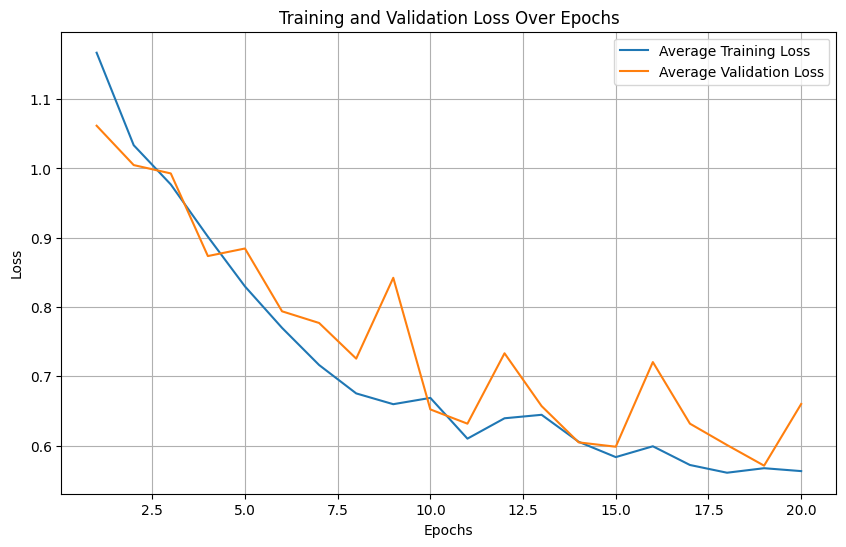

None
mlp_bilstm
twoyears
mlp_bilstm

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | fc1               | Linear              | 960    | train
1  | fc2               | Linear              | 2.1 K  | train
2  | fc3               | Linear              | 2.1 K  | train
3  | fc5               | Linear              | 165    | train
4  | norm1             | LayerNorm           | 64     | train
5  | norm2             | LayerNorm           | 128    | train
6  | norm3             | LayerNorm           | 64     | train
7  | lstm1             | LSTM                | 3.6 K  | train
8  | lstm2             | LSTM                | 16.9 K | train
9  | lstm3             |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

validation end


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 56: 'val_loss' reached 1.04351 (best 1.04351), saving model to '/content/lightning_logs/version_2/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 112: 'val_loss' reached 0.98381 (best 0.98381), saving model to '/content/lightning_logs/version_2/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 168: 'val_loss' reached 0.91299 (best 0.91299), saving model to '/content/lightning_logs/version_2/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 224: 'val_loss' reached 0.88088 (best 0.88088), saving model to '/content/lightning_logs/version_2/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 280: 'val_loss' reached 0.83954 (best 0.83954), saving model to '/content/lightning_logs/version_2/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 336: 'val_loss' reached 0.79549 (best 0.79549), saving model to '/content/lightning_logs/version_2/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 392: 'val_loss' reached 0.75258 (best 0.75258), saving model to '/content/lightning_logs/version_2/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 448: 'val_loss' reached 0.72980 (best 0.72980), saving model to '/content/lightning_logs/version_2/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 504: 'val_loss' reached 0.68469 (best 0.68469), saving model to '/content/lightning_logs/version_2/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 560: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 616: 'val_loss' reached 0.66043 (best 0.66043), saving model to '/content/lightning_logs/version_2/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 672: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 728: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 784: 'val_loss' reached 0.63522 (best 0.63522), saving model to '/content/lightning_logs/version_2/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 840: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 896: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 952: 'val_loss' reached 0.60976 (best 0.60976), saving model to '/content/lightning_logs/version_2/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 1008: 'val_loss' reached 0.59469 (best 0.59469), saving model to '/content/lightning_logs/version_2/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model mlp_bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 1064: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 1120: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


validation end
trainning end


Testing: |          | 0/? [00:00<?, ?it/s]

test end

predicted class raw tensor([[-6.6294, -1.7257, -0.3283, -2.3090, -6.8043],
        [-7.0507, -2.1074, -0.3288, -1.8547, -6.6524],
        [-7.6332, -2.5951, -0.2511, -1.9232, -7.1624],
        ...,
        [-6.5750, -1.9916, -0.3817, -1.7242, -6.8196],
        [-7.4994, -2.4909, -0.4223, -1.3471, -6.8465],
        [-5.7796, -2.2769, -0.5418, -1.1731, -5.7430]])


predicted class tensor([2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.2660377323627472     │
│        test_acc_v2        │    0.21387283504009247    │
│          test_f1          │    0.1097429171204567     │
│        test_f1_v2         │    0.11659921705722809    │
│      test_precision       │    0.16362005472183228    │
│     test_precision_v2     │    0.2699204385280609     │
│        test_recall        │    0.2660377323627472     │
│      test_recall_v2       │    0.21387283504009247    │
└───────────────────────────┴───────────────────────────┘

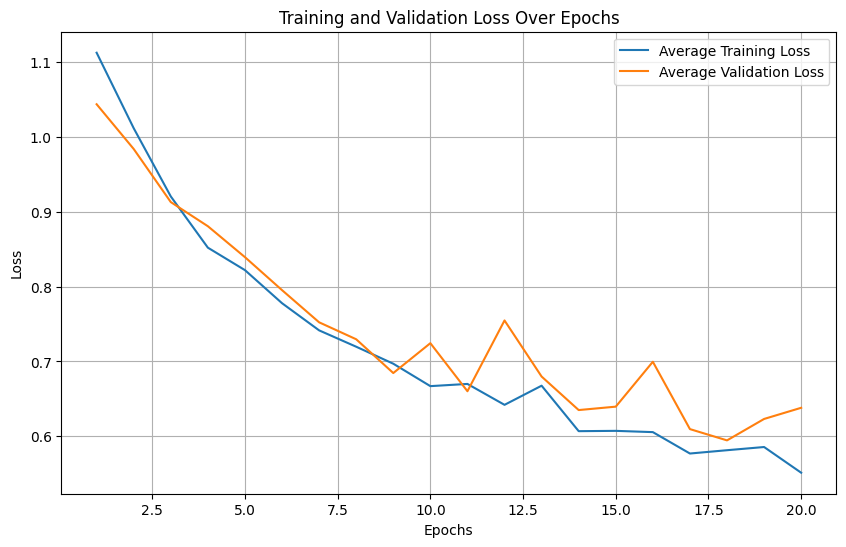

None
lstm
twoyears
lstm


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | model             | LSTM                | 6.1 K  | train
1  | fc                | Linear              | 85     | train
2  | loss_fn           | CrossEntropyLoss    | 0      | train
3  | train_acc         | MulticlassAccuracy  | 0      | train
4  | val_f1            | MulticlassF1Score   | 0      | train
5  | val_precision     | MulticlassPrecision | 0      | train
6  | val_recall        | MulticlassRecall    | 0      | train
7  | test_acc          | MulticlassAccuracy  | 0      | train
8  | test_f1           | MulticlassF1Score   | 0      | train
9  | test_precision    |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

validation end


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 56: 'val_loss' reached 1.45852 (best 1.45852), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 112: 'val_loss' reached 1.10797 (best 1.10797), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 168: 'val_loss' reached 1.05698 (best 1.05698), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 224: 'val_loss' reached 1.04738 (best 1.04738), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 280: 'val_loss' reached 1.04415 (best 1.04415), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 336: 'val_loss' reached 1.04133 (best 1.04133), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 392: 'val_loss' reached 1.04032 (best 1.04032), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 448: 'val_loss' reached 1.03790 (best 1.03790), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 504: 'val_loss' reached 1.03471 (best 1.03471), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 560: 'val_loss' reached 1.03154 (best 1.03154), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 616: 'val_loss' reached 1.02015 (best 1.02015), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 672: 'val_loss' reached 0.99712 (best 0.99712), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 728: 'val_loss' reached 0.94744 (best 0.94744), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 784: 'val_loss' reached 0.90545 (best 0.90545), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 840: 'val_loss' reached 0.87258 (best 0.87258), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 896: 'val_loss' reached 0.85980 (best 0.85980), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 952: 'val_loss' reached 0.83903 (best 0.83903), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 1008: 'val_loss' reached 0.82342 (best 0.82342), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 1064: 'val_loss' reached 0.80453 (best 0.80453), saving model to '/content/lightning_logs/version_3/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model lstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 1120: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


validation end
trainning end


Testing: |          | 0/? [00:00<?, ?it/s]

test end

predicted class raw tensor([[-3.2999, -1.4447, -0.5594, -2.2339, -3.0239],
        [-3.2330, -1.4801, -0.5938, -2.1099, -2.8220],
        [-3.2250, -1.4842, -0.5983, -2.0960, -2.7989],
        ...,
        [-3.2101, -1.4599, -0.5963, -2.1306, -2.8511],
        [-3.0320, -1.3266, -0.6283, -2.2612, -3.0219],
        [-3.2582, -1.4388, -0.5727, -2.2104, -2.9817]])


predicted class tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.25            │
│        test_acc_v2        │    0.18111753463745117    │
│          test_f1          │    0.07667210698127747    │
│        test_f1_v2         │   0.055546652525663376    │
│      test_precision       │    0.04527938365936279    │
│     test_precision_v2     │    0.03280355781316757    │
│        test_recall        │           0.25            │
│      test_recall_v2       │    0.18111753463745117    │
└───────────────────────────┴───────────────────────────┘

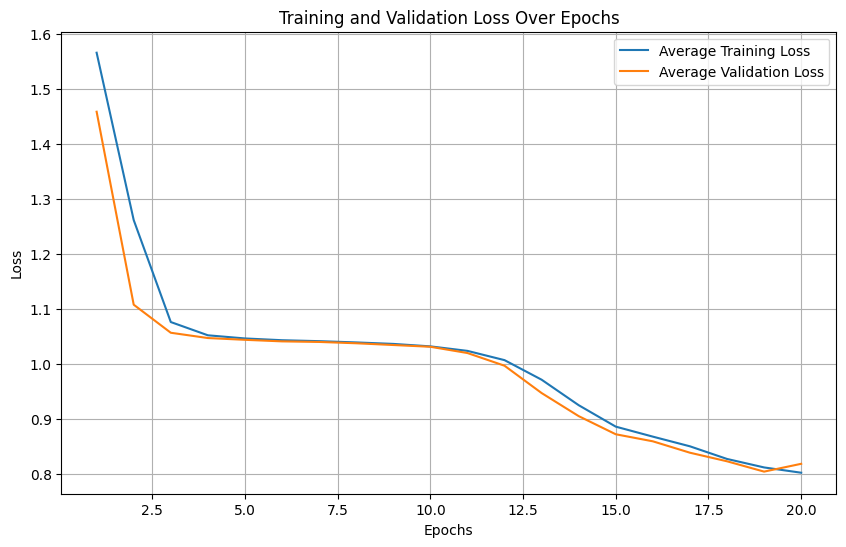

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


None
bilstm
twoyears
bilstm


INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | model             | LSTM                | 16.4 K | train
1  | fc                | Linear              | 165    | train
2  | loss_fn           | CrossEntropyLoss    | 0      | train
3  | train_acc         | MulticlassAccuracy  | 0      | train
4  | val_f1            | MulticlassF1Score   | 0      | train
5  | val_precision     | MulticlassPrecision | 0      | train
6  | val_recall        | MulticlassRecall    | 0      | train
7  | test_acc          | MulticlassAccuracy  | 0      | train
8  | test_f1           | MulticlassF1Score   | 0      | train
9  | test_precision    | MulticlassPrecision | 0      | train
10 | test_recall       | MulticlassRecall    | 0      | train
11 | test_acc_v2       | MulticlassAccuracy  | 0      | train

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

validation end


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 56: 'val_loss' reached 1.22632 (best 1.22632), saving model to '/content/lightning_logs/version_4/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 112: 'val_loss' reached 1.05386 (best 1.05386), saving model to '/content/lightning_logs/version_4/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 168: 'val_loss' reached 1.04329 (best 1.04329), saving model to '/content/lightning_logs/version_4/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 224: 'val_loss' reached 1.04093 (best 1.04093), saving model to '/content/lightning_logs/version_4/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 280: 'val_loss' reached 1.04032 (best 1.04032), saving model to '/content/lightning_logs/version_4/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 336: 'val_loss' reached 1.03577 (best 1.03577), saving model to '/content/lightning_logs/version_4/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 392: 'val_loss' reached 1.02122 (best 1.02122), saving model to '/content/lightning_logs/version_4/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 448: 'val_loss' reached 0.99191 (best 0.99191), saving model to '/content/lightning_logs/version_4/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 504: 'val_loss' reached 0.95907 (best 0.95907), saving model to '/content/lightning_logs/version_4/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 560: 'val_loss' reached 0.92937 (best 0.92937), saving model to '/content/lightning_logs/version_4/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 616: 'val_loss' reached 0.87739 (best 0.87739), saving model to '/content/lightning_logs/version_4/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 672: 'val_loss' reached 0.84670 (best 0.84670), saving model to '/content/lightning_logs/version_4/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 728: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 784: 'val_loss' reached 0.81723 (best 0.81723), saving model to '/content/lightning_logs/version_4/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 840: 'val_loss' reached 0.80059 (best 0.80059), saving model to '/content/lightning_logs/version_4/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 896: 'val_loss' reached 0.76661 (best 0.76661), saving model to '/content/lightning_logs/version_4/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 952: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 1008: 'val_loss' reached 0.73549 (best 0.73549), saving model to '/content/lightning_logs/version_4/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model bilstm.ckpt' as top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 1064: 'val_loss' was not in top 1


validation end
trainning end


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 1120: 'val_loss' reached 0.71479 (best 0.71479), saving model to '/content/lightning_logs/version_4/checkpoints/file_name data_clean_only_sem12tabular_lstm_size = 39, model bilstm.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


validation end
trainning end


Testing: |          | 0/? [00:00<?, ?it/s]

test end

predicted class raw tensor([[-3.6690, -1.4696, -0.5496, -2.0054, -3.4214],
        [-3.4513, -1.3333, -0.5800, -2.1665, -3.5006],
        [-3.4009, -1.3157, -0.5901, -2.1765, -3.4842],
        ...,
        [-3.3188, -1.3749, -0.6192, -2.0197, -3.2220],
        [-3.1267, -1.2500, -0.6446, -2.2028, -3.3736],
        [-3.4502, -1.4285, -0.5949, -1.9796, -3.2484]])


predicted class tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.25            │
│        test_acc_v2        │    0.18111753463745117    │
│          test_f1          │    0.07667210698127747    │
│        test_f1_v2         │   0.055546652525663376    │
│      test_precision       │    0.04527938365936279    │
│     test_precision_v2     │    0.03280355781316757    │
│        test_recall        │           0.25            │
│      test_recall_v2       │    0.18111753463745117    │
└───────────────────────────┴───────────────────────────┘

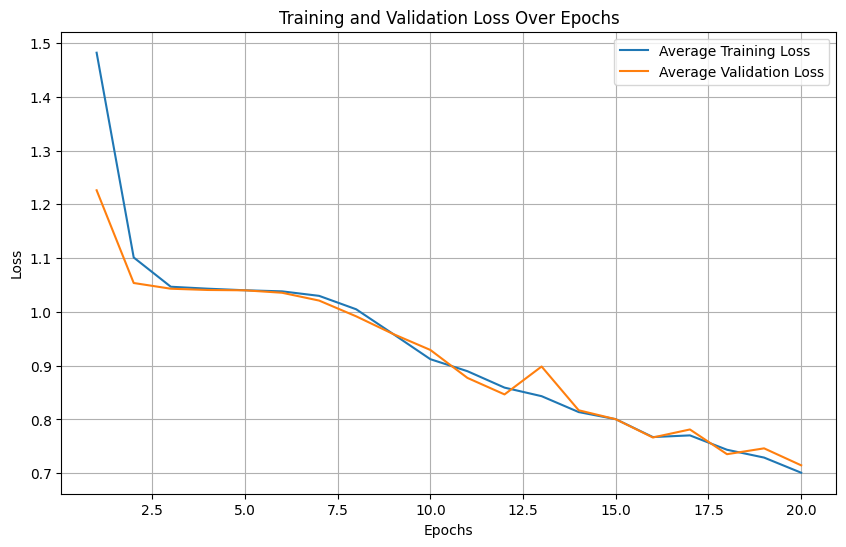

None


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

BASE_FOLER = '/content/drive/MyDrive/Nhóm 6 - DS317.P11/ĐỒ ÁN MÔN HỌC/3.data_processing/data-final/tabular_lstm/train-val-test-raw4label/'
# Main training function
def train_lstm_model(model_type,df,num_year):
    dataset_train = pd.read_csv(BASE_FOLER+'train_data.csv')
    dataset_test = pd.read_csv('/content/drive/MyDrive/Nhóm 6 - DS317.P11/ĐỒ ÁN MÔN HỌC/3.data_processing/data-final/tabular_lstm/train-val-test-4label/test_data.csv')
    dataset_val = pd.read_csv(BASE_FOLER+'val_data.csv')

    if num_year == 1:
      TABULAR_SIZE = 29
      TABULAR_LSTM_SIZE = 34 #2nam cho 3 hoc ki
      LSTM_SIZE = TABULAR_LSTM_SIZE - TABULAR_SIZE
      selected_cols = oneyear
    elif num_year==2:
      TABULAR_SIZE = 29
      TABULAR_LSTM_SIZE = 39 #2nam cho 3 hoc ki
      LSTM_SIZE = TABULAR_LSTM_SIZE - TABULAR_SIZE
      print("twoyears")
      selected_cols = twoyears
    elif num_year == 3:
      TABULAR_SIZE = 29
      TABULAR_LSTM_SIZE = 44 #2nam cho 3 hoc ki
      LSTM_SIZE = TABULAR_LSTM_SIZE - TABULAR_SIZE
      selected_cols = threeyears
    else:
      print("3.5 year")
      TABULAR_SIZE = 29
      TABULAR_LSTM_SIZE = 46 #2nam cho 3 hoc ki
      LSTM_SIZE = TABULAR_LSTM_SIZE - TABULAR_SIZE
      selected_cols = three5years

    dataset_train = dataset_train[selected_cols]
    dataset_test = dataset_test[selected_cols]
    dataset_val = dataset_val[selected_cols]
    #prepare data for trainning
    X_train = dataset_train.drop(columns=['mssv','label'])
    #X_train = dataset_train[oneyear].values
    X_train = X_train.iloc[:, :TABULAR_LSTM_SIZE].values  # Select the first 21 columns after dropping
    Y_train = dataset_train['label'].values

    #prepare data for testing
    x_test = dataset_test.drop(columns=['mssv','label'])
    #x_test = dataset_test[oneyear].values
    x_test = x_test.iloc[:, :TABULAR_LSTM_SIZE].values  # Select the first 21 columns after dropping
    y_test = dataset_test['label'].values

    #prepare data for testing
    x_val = dataset_val.drop(columns=['mssv','label'])
    #x_val = dataset_val[oneyear].values
    x_val = x_val.iloc[:, :TABULAR_LSTM_SIZE].values  # Select the first 21 columns after dropping
    y_val = dataset_val['label'].values

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)  # Long is required for classification labels
    X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    Y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    Y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Define model
    model = TabularTimeSeriesModel(input_size=LSTM_SIZE, hidden_size=16, num_layers=3, output_size=5,model_type=model_type)

    file_name = "data_clean_only_sem12"
    # Checkpoint callback
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",  # Monitor validation accuracy
        mode="min",  # Save the model with max validation accuracy
        save_top_k=1,  # Keep only the best model
        filename=f"file_name {file_name}tabular_lstm_size = {TABULAR_LSTM_SIZE}, model {MODEL_TYPE}",
        verbose=True
    )

    # Early stopping
    # early_stopping_callback = EarlyStopping(
    #     monitor="val_loss",
    #     mode="max",
    #     patience=5,
    #     verbose=True
    # )

    # Trainer
    trainer = pl.Trainer(
        max_epochs=20,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        callbacks=[checkpoint_callback],
        log_every_n_steps=10
    )

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Test the model
    trainer.test(model, dataloaders=test_loader)

    model.visualize_training(model.training_losses_avg, model.validation_losses_avg[1:])

# Run the training
if __name__ == "__main__":
  # Initialize an empty DataFrame with the required fields
  # Run the training for each MODEL_TYPE
  # ['mlp','mlp_lstm','mlp_bilstm','lstm','bilstm']
  for MODEL_TYPE in ['mlp','mlp_lstm','mlp_bilstm','lstm','bilstm']:
    print(MODEL_TYPE)
    df = train_lstm_model(MODEL_TYPE,empty_results_df,num_year =2)
    print(df)
